In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import pickle
import sklearn
from sklearn.utils import class_weight
import time
from sklearn import metrics
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [101]:
%run SharedFunctions.ipynb

Učitava se prethodno pripremljen skup podataka: 

In [3]:
data = pd.read_csv('data/data_longer.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
data.shape

(223453, 9)

### 1. Podela na trening, test, i validacioni skup

In [5]:
# Ovo je prepisano iz prethodne sveske

train_size = 159571 - 96
test_size = 63978
validation_size = int(0.2*train_size)
train_size = train_size - validation_size

validation_data = data[:validation_size]
train_data = data[validation_size:train_size+validation_size]
test_data = data[train_size+validation_size : ]

train_data.shape[0], test_data.shape[0], validation_data.shape[0]

(127580, 63978, 31895)

### 2. Tokenizacija I vektorizacija teksta

In [6]:
# uzima se recimo 20000 najfrekventinijh reci
max_features = 20000

# max duzina
max_len = 100

In [7]:
word_index, tokenizer = get_vocabulary(max_features, train_data, 'tokenizer_binary.pickle')

In [8]:
print('Broj jedinstvenih reci:', len(word_index))

Broj jedinstvenih reci: 187048


Sada pravimo skupove za trening, test i validaciju sa vektorizovanim tekstom

In [9]:
X_train = to_sequence(train_data['comment_text'], max_len, tokenizer)
X_test = to_sequence(test_data['comment_text'], max_len, tokenizer)
X_validation = to_sequence(validation_data['comment_text'], max_len, tokenizer)

In [10]:
X_train.shape, X_test.shape, X_validation.shape

((127580, 100), (63978, 100), (31895, 100))

In [11]:
y_train = train_data['target']
y_test = test_data['target']
y_validation = validation_data['target']

Kreira se matrica ugnjezdavanja

In [12]:
embedding_matrix = create_embedding_matrix(word_index, max_len)

### 3. Formiranje modela

In [73]:
kernel_size = 3
pool_size = 4
filters = 64
dropout_rate = 0.3

In [74]:
binary_model = create_model(num_of_classes = 2, num_of_features = max_features, embedding_dim = 100, 
                kernel_size = kernel_size, pool_size = pool_size, filters = filters, 
                dropout_rate = dropout_rate, maxlen = max_len, embedding_matrix = embedding_matrix)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 100, 64)           19264     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 25, 64)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 25, 64)            12352     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 6, 64)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 64)             0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)               

### 4. Obučavanje modela

In [76]:
weights = get_weights(y_train)
weights

{0: 0.5563210772343543, 1: 4.9388355528027255}

In [77]:
epochs = 10
batch_size = 128

In [78]:
start = time.time()    

binary_history = binary_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                                 validation_data=(X_validation, y_validation), class_weight=weights)
                                 #,callbacks=[early_stop]
                                 
print('Trajanje obucavanja modela binarne klasifikacije: ', time.time() - start)

Epoch 1/10
997/997 [==============================] - 43s 43ms/step - loss: 0.5223 - accuracy: 0.7520 - val_loss: 0.4104 - val_accuracy: 0.8228
Epoch 2/10
997/997 [==============================] - 40s 40ms/step - loss: 0.3758 - accuracy: 0.8499 - val_loss: 0.3760 - val_accuracy: 0.8592
Epoch 3/10
997/997 [==============================] - 26s 26ms/step - loss: 0.3347 - accuracy: 0.8802 - val_loss: 0.3176 - val_accuracy: 0.8900
Epoch 4/10
997/997 [==============================] - 24s 25ms/step - loss: 0.3143 - accuracy: 0.8915 - val_loss: 0.2631 - val_accuracy: 0.9140
Epoch 5/10
997/997 [==============================] - 27s 28ms/step - loss: 0.2993 - accuracy: 0.9005 - val_loss: 0.2905 - val_accuracy: 0.9024
Epoch 6/10
997/997 [==============================] - 27s 27ms/step - loss: 0.2896 - accuracy: 0.9037 - val_loss: 0.3430 - val_accuracy: 0.8807
Epoch 7/10
997/997 [==============================] - 27s 27ms/step - loss: 0.2809 - accuracy: 0.9068 - val_loss: 0.2854 - val_accuracy:

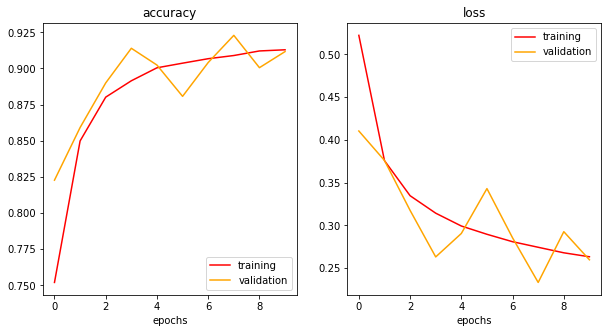

In [79]:
plot_graphs(binary_history, ['accuracy', 'loss'])

### 5. Evaluacija modela

In [80]:
scores = binary_model.evaluate(X_test, y_test)
scores

2000/2000 [==============================] - 8s 4ms/step - loss: 0.4687 - accuracy: 0.8441


[0.46872419118881226, 0.844102680683136]

In [81]:
y_pred = binary_model.predict(X_test)

In [82]:
new_class = [int(score > 0.5) for score in y_pred]
metrics.accuracy_score(y_test, new_class)

0.8441026602894746

In [112]:
cf = metrics.confusion_matrix(y_test, new_class)
print(cf)

[[48330  9401]
 [  573  5674]]


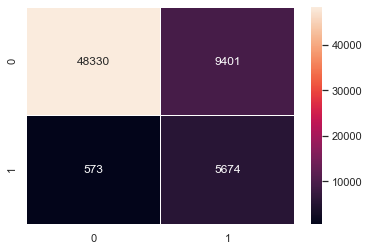

In [122]:
import seaborn as sns

sns.heatmap(cf, annot=True, fmt="d", linewidths=.5)
plt.show()